# Constraining parameters

So, how to use IMAGINE to constrain a set of models given a particular dataset?
This section dicusses some approaches to this problem using different tools available within IMAGINE.
It assumes that the reader went through the parts of the documentation which describe the [main
components of IMAGINE](components.rst) and/or went through some of the [tutorials](tutorial_one.ipynb).

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import imagine as img


## Setting up an example problem

We start by setting up an example problem similar to the one in [first tutorial](tutorial_one.ipynb). Where we have a constant magnetic field, thermal electron density given by:
$$
n_e(x,y,z) = n_0  [1+ \cos(a x + \alpha)]
$$

and a signal given by

$$
s(x) = B_y n_e(x) = B_y n_0 [1+ \cos(a x + \alpha)]
$$

First we generate mock data.

In [2]:
# Prepares fields/grid for generating mock data
one_d_grid = img.fields.UniformGrid(box=[[0,2*np.pi]*u.kpc,
                                         [0,0]*u.kpc,
                                         [0,0]*u.kpc],
                                    resolution=[55,1,1])

ne_field = img.fields.CosThermalElectronDensity(grid=one_d_grid, 
                                                parameters={'n0': 0.5*u.cm**-3,
                                                            'a': 1.0/u.kpc*u.rad,
                                                            'b': 0.0/u.kpc*u.rad,
                                                            'c': 0.0/u.kpc*u.rad,
                                                            'alpha': 0.5*u.rad,
                                                            'beta':  np.pi/2*u.rad,
                                                            'gamma': np.pi/2*u.rad})

B_field = img.fields.ConstantMagneticField(grid=one_d_grid, 
                                           parameters={'Bx': 2*u.microgauss, 
                                                       'By': 0.5*u.microgauss,
                                                       'Bz': 0.2*u.microgauss})
true_model = [ne_field, B_field]

# Generates a fake dataset to establish the format of the simulated output
size = 30; x = np.linspace(0.001,2*np.pi, size); yz = np.zeros_like(x)*u.kpc
fake_dset = img.observables.TabularDataset(data={'data': x, 'x': x*u.kpc,
                                                 'y': yz, 'z': yz},
                                           units=u.microgauss*u.cm**-3, 
                                           name='test', data_col='data')
trigger = img.observables.Measurements(fake_dset)

# Prepares a simulator to generate the mock observables
mock_generator = img.simulators.TestSimulator(trigger)

# Creates simulation from these fields
simulation = mock_generator(true_model)

# Converts the simulation data into a mock observational data (including noise) 
key = list(simulation.keys())[0]
sim_data = simulation[key].global_data.ravel()
err = 0.01
noise = np.random.normal(loc=0, scale=err, size=size)
mock_dset = img.observables.TabularDataset(data={'data': sim_data + noise,
                                                 'x': x,
                                                 'y': np.zeros_like(x),
                                                 'z': np.zeros_like(x),
                                                 'err': np.ones_like(x)*err},
                                                 units=u.microgauss*u.cm**-3, 
                                                 name='test', data_col='data')
mock_measurements = img.observables.Measurements(mock_dset)

Now, we proceed with the other components: the simulator, the likelihood, the field factories list.

In [3]:
# Initializes the simulator and likelihood object, using the mock measurements
simulator = img.simulators.TestSimulator(mock_measurements)
likelihood = img.likelihoods.SimpleLikelihood(mock_measurements)

# Generates factories from the fields (any previous parameter choices become defaults)
ne_factory = img.fields.FieldFactory(ne_field, active_parameters=['n0', 'alpha'],
                                     priors={'n0': img.priors.GaussianPrior(mu=1*u.cm**-3, 
                                                                            sigma=0.9*u.cm**-3,
                                                                            xmin=0*u.cm**-3,
                                                                            xmax=10*u.cm**-3),
                                             'alpha': img.priors.FlatPrior(-np.pi, np.pi, u.rad, wrapped=True),
                                             'a': img.priors.FlatPrior(0.01, 10, u.rad/u.kpc)})

B_factory = img.fields.FieldFactory(B_field, active_parameters=['By'],
                                     priors={'By': img.priors.FlatPrior(-10,10, u.microgauss),})

Finally, we assemble the pipeline itself. For sake of definiteness and for illustration, we use the `DynestyPipeline`.

In [4]:
# Initializes the pipeline
pipeline = img.pipelines.DynestyPipeline(run_directory=img.rc['temp_dir']+'/fitting/',
                                         factory_list=[B_factory, ne_factory],
                                         simulator=simulator, 
                                         likelihood=likelihood,
                                         show_summary_reports=False)

Once we have our setup, it is always good to use the `test` method to check if the pipeline is actually working (simple errors as missing prior specifications or malfunctioning Fields can be easily isolated this way).

In [5]:
pipeline.test()

Sampling centres of the parameter ranges.
	Evaluating point: [0.0, 5.0, 0.0]
	Log-likelihood -1.4600680317743122
	Total execution time:  0.0026073716580867767 s

Randomly sampling from prior.
	Evaluating point: [-7.43751104  3.83322458 -1.65820186]
	Log-likelihood -18197.732060368326
	Total execution time:  0.002800416201353073 s

Randomly sampling from prior.
	Evaluating point: [-2.06838545  0.93330396  1.0665458 ]
	Log-likelihood -108.03886313649168
	Total execution time:  0.002597574144601822 s

Average execution time: 0.0026684540013472238 s


<Quantity 0.00266845 s>

## MAP estimates

The most common question that arises when one is working with a new parametrised model is "what does the *best fit* model look like"? There is plenty of reasons to approach this question very cautiously: a single point in the parameter space generally cannot encompass full predictive power of a model, as one has to account for the uncertainties and incomplete prior knowledge. In fact, this is one of the reasons why a full Bayesian approach as IMAGINE is deemed necessary in first place. That said, there are at least two common situations where a *point estimate* is desirable/useful. *After* performing the inference, adequately sampling posterior and clarifying the [credible intervals](https://en.wikipedia.org/wiki/Credible_interval), one may want to use a well motivated example of the model for another purpose. A second common situation is, when designing a new model proposal where some parameters are roughly known, to examine the best fit solution with respect to the less known parameters: often, the qualitative insights of this procedure are sufficient for rulling out or improving the model, even before the full inference.

Any IMAGINE `Pipeline` object comes with the method [Pipeline.get_MAP()](imagine.pipelines.rst#imagine.pipelines.pipeline.Pipeline.get_MAP),
which maximizes the product of the likelihood and the prior,
$\hat{\theta}_{\rm MAP} = \rm{arg}\max_{\theta}  \mathcal{L}(\theta)\pi(\theta)\,$,
which corresponds to the mode of the posterior distribution, i.e.
the [MAP (Maximum A Posteriori)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation). 



In [6]:
MAP_values = pipeline.get_MAP()
for parameter_name, parameter_value in zip(pipeline.active_parameters, MAP_values):
    print(parameter_name + ': ', parameter_value)

constant_B_By:  0.24858178201289644 uG
cos_therm_electrons_n0:  1.0006675426910474 1 / cm3
cos_therm_electrons_alpha:  0.5027776818628544 rad


As it is seen above, the `get_MAP()` method returns the values of the posterior mode. This is *not found* using the sampler, but instead using the scipy optimizer, `scipy.optimize.minimize`. If the sampler *had run* before, the median of the posterior is used as initial guess by the optimizer. If this is not the case,
the optimizer will use the centre of the ranges as a starting position. Alternatively, the user can provide an initial guess using the `initial_guess` keyword argument (which is useful in the case of multimodal posteriors).

Whenever `get_MAP()` is called, the MAP value found is saved internally. This is used by the two convenience properties: `Pipeline.MAP_model` and `Pipeline.MAP_simulation`, which return a list of IMAGINE `Field` objects at the MAP and the corresponding `Simulations` object, respectively. To illustrate all this, let us inspect the associated MAP model and compare its simulation with the original mock.

MAP model:

 constant_B
	 Bx 	 2.0 uG
	 By 	 0.24858178201289644 uG
	 Bz 	 0.2 uG

 cos_therm_electrons
	 n0 	 1.0006675426910474 1 / cm3
	 a 	 1.0 rad / kpc
	 b 	 0.0 rad / kpc
	 c 	 0.0 rad / kpc
	 alpha 	 0.5027776818628544 rad
	 beta 	 1.5707963267948966 rad
	 gamma 	 1.5707963267948966 rad



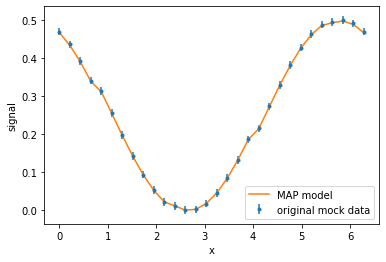

In [7]:
print('MAP model:')
for field in pipeline.MAP_model:
    print('\n',field.name)
    for p, v in field.parameters.items():
        print('\t',p,'\t',v)
print()
plt.errorbar(x, sim_data, err, marker='.', linestyle='none', label='original mock data')
plt.plot(x, pipeline.MAP_simulation[key].global_data[0],  label='MAP model')
plt.xlabel('x'); plt.ylabel('signal'); plt.legend();

The plot indicates that the fitting is working. However, the values parameter values differ from the true model:

In [8]:
print('True model:')
for field in true_model:
    print('\n',field.name)
    for p, v in field.parameters.items():
        print('\t',p,'\t',v)

True model:

 cos_therm_electrons
	 n0 	 0.5 1 / cm3
	 a 	 1.0 rad / kpc
	 b 	 0.0 rad / kpc
	 c 	 0.0 rad / kpc
	 alpha 	 0.5 rad
	 beta 	 1.5707963267948966 rad
	 gamma 	 1.5707963267948966 rad

 constant_B
	 Bx 	 2.0 uG
	 By 	 0.5 uG
	 Bz 	 0.2 uG


The reason for the difference are the degeneracy between the electron density  and the y-component of the magnetic field for this observable (which  merely computes the product $n_e B_y$).  The reason why the MAP lands close to $1\,{\rm cm}^{-3}$ is because of our prior knowledge about the parameter `n0`, namely that it should be approximately $n_0 = (1 \pm 0.9)\,{\rm cm}^{-3}$.
We can inspect the previous prior choices in the following way.

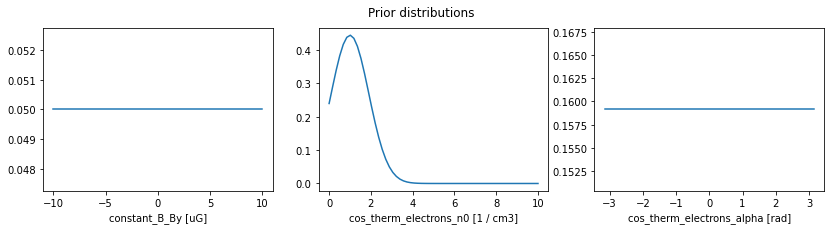

In [9]:
plt.figure(figsize=(14,3))
for i, pname in enumerate(pipeline.priors):
    prior = pipeline.priors[pname]
    t = np.linspace(*prior.range, 60)
    plt.subplot(1,3,i+1)
    plt.plot(t, prior.pdf(t))
    plt.xlabel('{} [{}]'.format(pname, prior.unit))
plt.suptitle('Prior distributions');

## Sampling the posterior

To go beyond a *point estimates* as the MAP it is necessary to sample the posterior distribution.
From the posterior samples it is possible to understand the *[credible regions](https://en.wikipedia.org/wiki/Credible_interval)*
in the parameter space and better grasp the physical consequences a given parameters choice.

Among other things, knowledge of the posterior also allows one to examine *degeneracies* in the model parameters, as the one exemplified above.

Once a pipeline object is assembled, one can "run" it, i.e. one can use it to produce samples of the posterior distribution.
How exactly this is done will the depend on which specific `Pipeline` sub-class one is using.  


### Nested sampling

Many of the [Pipeline](imagine.pipelines.rst#module-imagine.pipelines.pipeline) classes use samplers 
based on [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm), 
an algorithm originally designed for accurately estimate of the [evidence](tutorial_fitting.ipynb) (or marginal likelihood),
but which can also be used to sample the posterior distribution. 
Nested sampling potentially performs better if the distributions are multimodal, but can be inefficient,
specially if a given parameter has a small or negligible effect.

There are three nested-sampling-based `Pipeline` classes in IMAGINE:
[MultinestPipeline](imagine.pipelines.rst#module-imagine.pipelines.multinest_pipeline),
[UltranestPipeline](imagine.pipelines.rst#module-imagine.pipelines.ultranest_pipeline),
[DynestyPipeline](imagine.pipelines.rst#module-imagine.pipelines.dynesty_pipeline).

[DynestyPipeline](imagine.pipelines.rst#module-imagine.pipelines.dynesty_pipeline) allows one to use the parameter `pfrac` to control [how much the sampling should focus on the posterior rather
than on the evidence](https://dynesty.readthedocs.io/en/latest/dynamic.html?highlight=pfrac#dynamic-vs-static). Since we are not interested in the evidence in this example, let us set this to 1 (maximum priority to the
posterior).

In [10]:
pipeline.sampling_controllers = {'nlive_init': 70, 'pfrac':1}
# Runs the pipeline
pipeline();

21586it [09:40, 37.19it/s, batch: 22 | bound: 51 | nc: 10 | ncall: 231179 | eff(%):  9.337 | loglstar: -9.219 < -0.002 < -0.318 | logz: -4.079 +/-  0.095 | stop:  0.955]       


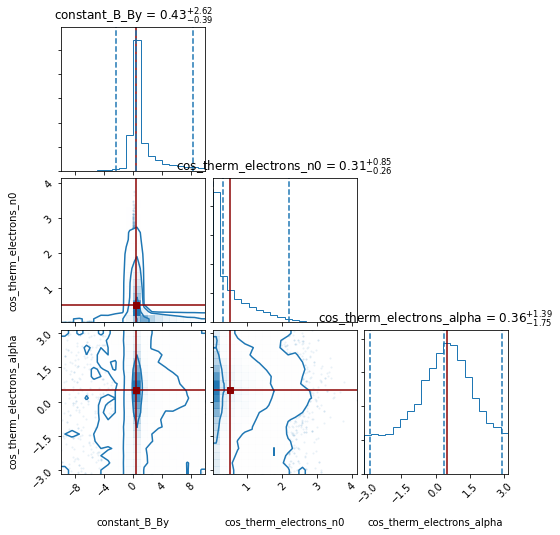

In [11]:
pipeline.corner_plot(truths_dict= {'constant_B_By': 0.5 ,
                                   'cos_therm_electrons_n0':  0.5,
                                   'cos_therm_electrons_alpha':  0.5});

### MCMC

It is also possible to sample the posterior distribution using the [emcee](https://emcee.readthedocs.io/), a MCMC ensemble sampler.
The disadvantages of this approach is that it may have difficulties with multimodal distributions and does not automatically estimate the evidence. On the other hand,
it allows someone to transfer previous experience/intuition in the use of MCMC to IMAGINE.

IMAGINE's [EmceePipeline](imagine.pipelines.rst#module-imagine.pipelines.emcee_pipeline)
uses the simple convergence criterion described, for example, in 
[Emcee's documentation](https://emcee.readthedocs.io/en/v3.0.2/tutorials/monitor/#saving-monitoring-progress),
which is based on the estimation of the autocorrelation time:
every `nsteps_check` steps, the autocorrelation time, $\tau$ is estimated, if 
`convergence_factor`$\times\tau$ is larger than the number of steps, and 
$\tau$ changed less than $1\%$ since the last check, the run is assumed to have converged.

In [12]:
pipeline_emcee = img.pipelines.EmceePipeline(run_directory=img.rc['temp_dir']+'/emcee',
                                             factory_list=[B_factory, ne_factory],
                                             simulator=simulator, 
                                             likelihood=likelihood)

In [13]:
pipeline_emcee.sampling_controllers = {'nsteps_check':500,'max_nsteps':1500}

100%|██████████| 500/500 [00:26<00:00, 18.72it/s]



**Posterior report:**

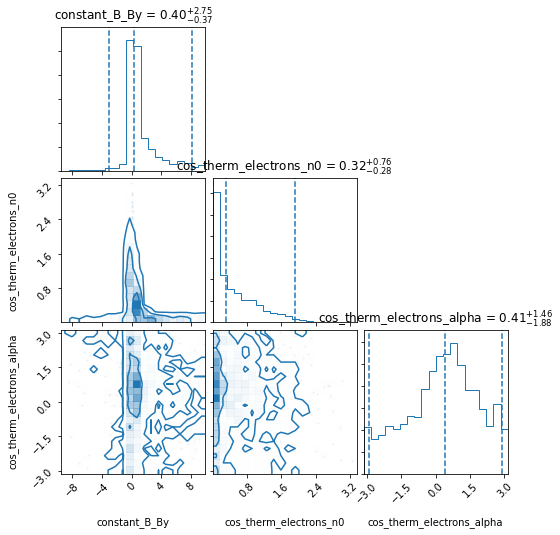

<IPython.core.display.Math object>

Has the run converged yet? False


In [14]:
pipeline_emcee();
print('Has the run converged yet?', pipeline_emcee.converged)

One can see that the above EmceePipeline ran only for about 1.5 minute and *did not converge*, but this could already provide some insight in its posterior contours. If we call the pipeline again it will resume the work.

100%|██████████| 500/500 [00:26<00:00, 18.54it/s]



**Posterior report:**

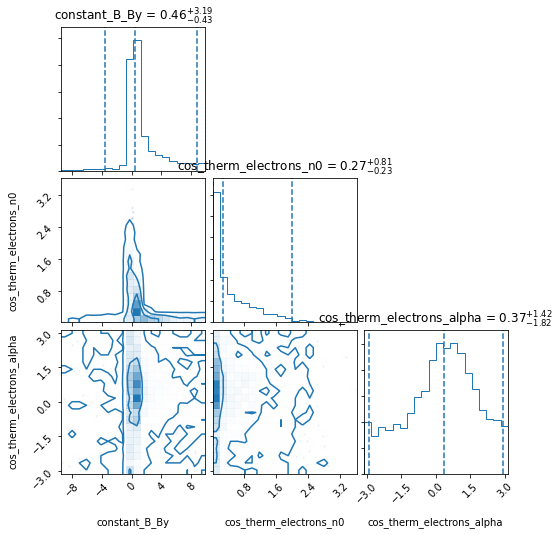

<IPython.core.display.Math object>

Has the run converged yet? False


In [15]:
pipeline_emcee();
print('Has the run converged yet?', pipeline_emcee.converged)

## Constraining parameters of stochastic fields

So far, we only worked with deterministic fields. However, some of the fields modelled may be stochastic
components (i.e. the same choice of parameters may lead to different outputs).
A crucial example is the random (or "small-scale) component of the Galactic magnetic field.

IMAGINE deals with stochastic fields by evaluating an ensemble of realisations of the stochastic fields and accounting for their variability in the likelihood calculation. How exactly this is done depends on 

Let us look at an example. We will re-use some the elements of the previous sections, but we will assume that the magnetic field is comprised of two components: a large scale constant one (as before), and a Gaussian random field, with $\langle b \rangle = 0$ and
$(\langle b^2)^{1/2} = 1\mu{\rm G}$. 

In [16]:
B_field_rnd = img.fields.NaiveGaussianMagneticField(
    grid=one_d_grid, parameters={'a0': 0.0*u.microgauss, 'b0': 1*u.microgauss})
true_model_rnd = [ne_field, B_field, B_field_rnd]

# Creates simulation from these fields
simulation = mock_generator(true_model_rnd)

# Converts the simulation data into a mock observational data (including noise) 
key = list(simulation.keys())[0]
sim_data = simulation[key].global_data.ravel()
err = 0.01
noise = np.random.normal(loc=0, scale=err, size=size)
mock_dset = img.observables.TabularDataset(data={'data': sim_data + noise,
                                                 'x': x,
                                                 'y': np.zeros_like(x),
                                                 'z': np.zeros_like(x),
                                                 'err': np.ones_like(x)*err},
                                                 units=u.microgauss*u.cm**-3, 
                                                 name='test',
                                                 data_col='data',
                                                 err_col='err')
mock_measurements = img.observables.Measurements(mock_dset)

As this pipeline will involve stochastic fields, we use the [EnsembleLikelihood](imagine.likelihoods.html#imagine.likelihoods.ensemble_likelihood.EnsembleLikelihood) class. 
Oftentimes one does not know a priori what is the required ensemble size. For definiteness, we will
start with `ensemble_size=20`, run some diagnostics, and readjust the ensemble size later.

In [17]:
# Initializes the simulator and likelihood object, using the mock measurements
simulator = img.simulators.TestSimulator(mock_measurements)
likelihood = img.likelihoods.EnsembleLikelihood(mock_measurements)

# Generates factories from the fields (any previous parameter choices become defaults)
ne_factory = img.fields.FieldFactory(ne_field, active_parameters=[])

muG = u.microgauss
B_factory = img.fields.FieldFactory(B_field, active_parameters=['By'],
                                     priors={'By': img.priors.FlatPrior(-5,5, u.microgauss)})


B_factory_rnd = img.fields.FieldFactory(B_field_rnd, active_parameters=['b0'],
                                        priors={'b0': img.priors.FlatPrior(0,5, u.microgauss)})

# Initializes the pipeline
pipeline = img.pipelines.MultinestPipeline(run_directory=img.rc['temp_dir']+'/fitting_rnd/',
                                           factory_list=[B_factory_rnd, B_factory, ne_factory],
                                           simulator=simulator, 
                                           likelihood=likelihood,
                                           show_summary_reports=False,
                                           ensemble_size=20)
# A quick test
pipeline.test(1)

Sampling centres of the parameter ranges.
	Evaluating point: [2.5, 0.0]
	Log-likelihood -41.1364592408928
	Total execution time:  0.021514978259801865 s

Average execution time: 0.021514978259801865 s


<Quantity 0.02151498 s>

So, how to choose the ensemble size? The ensemble should be large enough to provide a good estimate ensemble likelihood. There are two facets of this: first, the likeliood value must converge (i.e. increasing the ensemble size should not affect the likelihood significantly); secondly, the dispersion of likelihood values (i.e. the variation of the likelihood due to different random numbers in for generating the ensemble), should be small.

An IMAGINE pipeline comes with the [Pipeline.prepare_likelihood_convergence_report](imagine.pipelines.pipeline.Pipeline.prepare_likelihood_convergence_report) 
for quickly examining these two aspects. 
The method computes the likelihood for multiple ensemble sizes (allowing one to track the likelihood convergence)
and estimates the likelihood dispersion by bootstrapping the ensembles and taking the standard deviation
of the resampled likelihood values. Of course, the likelihood can only be computed for individual points in
the parameter space. The method addresses this by randomly drawing a number of points from the prior distribution
(optionally, for convenience, it also includes the centres of the intervals, to have a fixed and intuitive
reference point).

One can either directly access the report data directly, using the method [Pipeline.prepare_likelihood_convergence_report](imagine.pipelines.pipeline.Pipeline.prepare_likelihood_convergence_report), or look at set of standard plot
containing it, using the method
[Pipeline.likelihood_convergence_report](imagine.pipelines.html#imagine.pipelines.pipeline.Pipeline.likelihood_convergence_report):

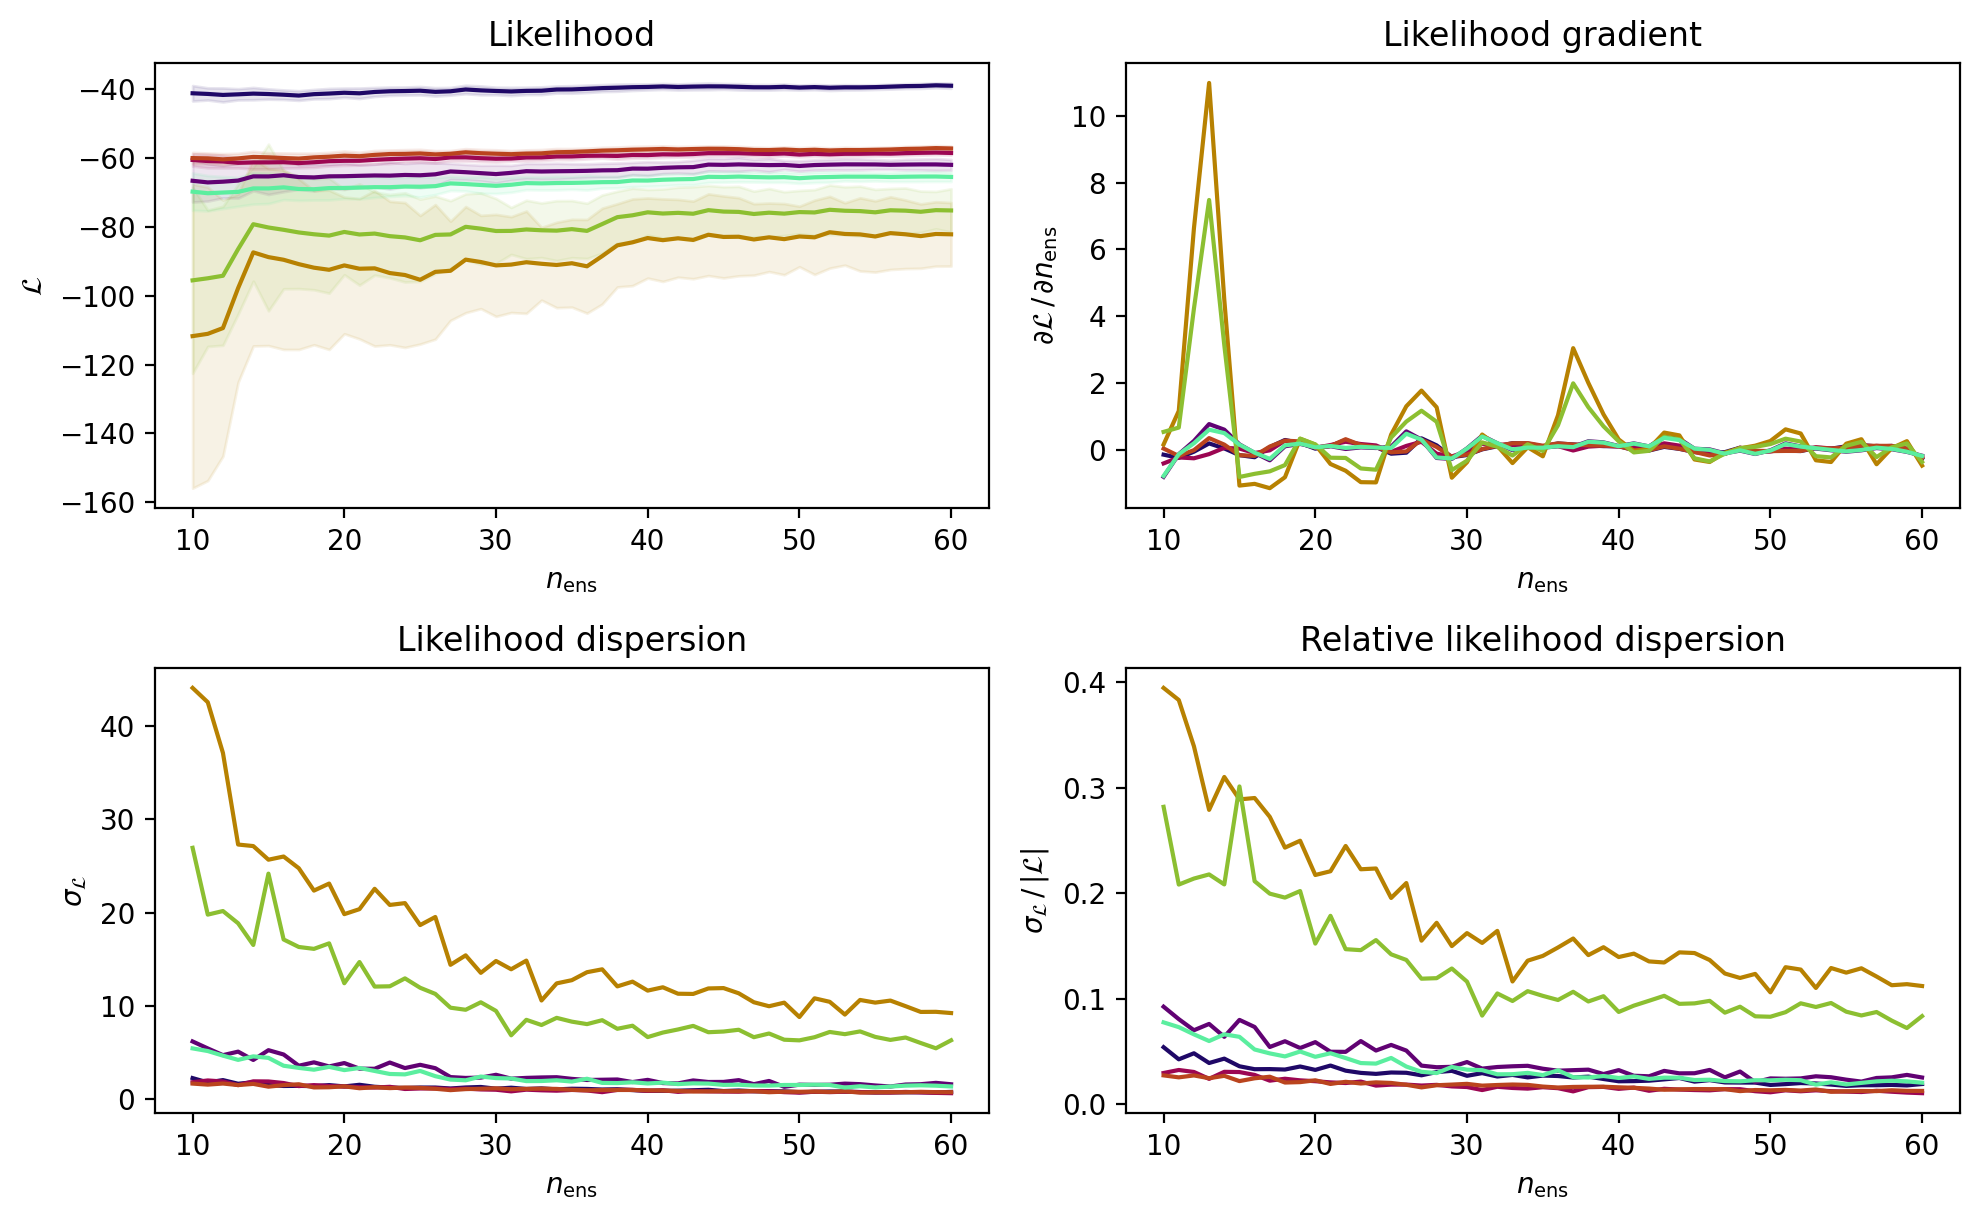

In [18]:
pipeline.likelihood_convergence_report(
    min_Nens=10,
    max_Nens=60,
    n_points=7,
    include_centre=True)

These plots indicate that the likelihood and its dispersion stabilise (approximately) between `ensemble_size=30` and `40`. Also, the dispersion is only of few percent for the points in the parameter space with the highest likelihood. Armed with this information we will provisionally set the ensemble size.

In [19]:
pipeline.ensemble_size = 35

In [ ]:
pipeline.sampling_controllers = {'evidence_tolerance': 0.5, 'n_live_points': 200}
pipeline();

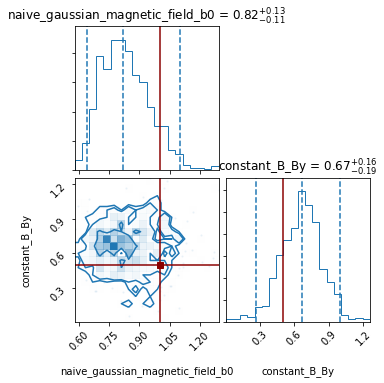

In [21]:
pipeline.corner_plot(truths_dict= {'constant_B_By': 0.5 ,
                                   'naive_gaussian_magnetic_field_b0':  1});